# Generación de visualización

In [272]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import lines as mlines

from aves.models.network import Network
from aves.visualization.networks import NodeLink

## Carga de datos

In [273]:
vote_df = pd.read_csv("data/votos.csv", index_col=0)

In [274]:
deputy_df = pd.read_csv("data/diputados.csv", index_col=0)

In [275]:
deputy_df["diputado"] = deputy_df["nombre"] + " " + deputy_df["apellido"]

## Cálculo de red

Para cada par de diputados, calcularemos el **porcentaje de acuerdo** entre
ambos. Esto es el **porcentaje de votaciones en que ambos diputados votaron de
igual manera**, considerando solo los casos en que la votación obtuvo entre un
20% y 80% de sufragios a favor (para no considerar decisiones unánimes).

In [276]:
# cambiamos los votos no válidos (dispensado y no vota) por nulos, solo dejando
# 0 (en contra), 1 (afirmativo) y 2 (abstención)
vote_df = vote_df.replace(
    {
        3: np.nan,
        4: np.nan
    }
)

In [277]:
pct_vote = vote_df.apply(
    lambda column:
    1.0 if column.count() == 0
    else (column == 1).sum() / column.count()
)

In [278]:
vote_df = vote_df.loc[:, (pct_vote < 0.8) & (pct_vote > 0.2)]

In [279]:
# para cada par de diputados, calculamos la cantidad de votaciones en que ambos
# votaron lo mismo
result = []
for _, row in vote_df.iterrows():
    row_result = []
    for _, column in vote_df.iterrows():
        common_votes = (row.notna() & column.notna()).sum()
        if common_votes == 0:
            row_result.append(np.nan)
        else:
            row_result.append((row == column).sum() / common_votes)
    result.append(row_result)
    
pct_equal_votes = pd.DataFrame(
    result, index=vote_df.index, columns=vote_df.index
)

In [280]:
# dejamos solo las filas donde el primer diputado tiene un nombre
# lexicográficamente mayor al segundo (para evitar duplicados)
deputy_pairs = (
    pct_equal_votes
    .rename_axis(index="source", columns="target")
    .stack()
    .dropna()
    .reset_index()
    .rename(columns={0: "percent"})
)[lambda x: x["source"] > x["target"]]

In [281]:
# agregamos información de cada diputado involucrado, y usamos el nombre como
# índice en vez de la ID
deputy_pairs = deputy_pairs.merge(
    deputy_df[["diputado", "partido"]],
    left_on="source",
    right_index=True
).merge(
    deputy_df[["diputado", "partido"]],
    left_on="target",
    right_index=True,
    suffixes=("_source", "_target")  
).drop(
    columns=["source", "target"]
).rename(
    columns={"diputado_source": "source", "diputado_target": "target"}
)

In [282]:
deputy_pairs.sample(10, random_state=0)

,percent,source,partido_source,target,partido_target
16812,0.085878,Catalina Pérez,Frente Amplio,Sergio Bobadilla,Unión Demócrata Independiente
12422,0.788364,Christian Matheson,Independientes,Marta Bravo,Unión Demócrata Independiente
24574,0.806194,Mercedes Bulnes,Independientes,Emilia Nuyado,Partido Socialista
10679,0.592488,Tomás Lagomarsino,Independientes,Mónica Arce,Independientes
3618,0.790133,Ana María Bravo,Partido Socialista,Boris Barrera,Partido Comunista
9716,0.686874,Juan Irarrázaval,Partido Republicano,Francisco Undurraga,Evolución Política
19360,0.900102,Patricio Rosas,Frente Amplio,Diego Ibáñez,Frente Amplio
7795,0.931687,Lorena Fries,Frente Amplio,Catalina Pérez,Frente Amplio
23705,0.152519,Flor Weisse,Unión Demócrata Independiente,Mónica Arce,Independientes
12118,0.186978,Cristóbal Martínez,Unión Demócrata Independiente,Daniella Cicardini,Partido Socialista


Observamos que incluso diputados en extremos opuestos del hemiciclo tienen un
cierto porcentaje de acuerdo (cercano al 10%), por lo cual solo consideraremos
como un enlace en la red aquellos pares que tengan más de un 50% de acuerdo
(línea roja en el histograma inferior).

Text(0, 0.5, 'Cantidad de pares')

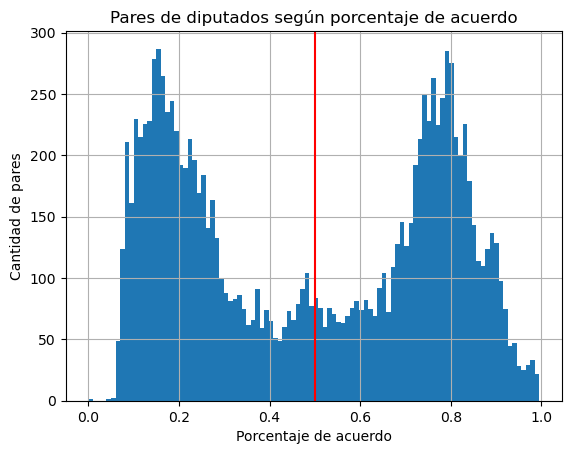

In [283]:
fig, ax = plt.subplots()

deputy_pairs.hist("percent", bins=100, ax=ax)
ax.axvline(0.5, color="red")
ax.set_title("Pares de diputados según porcentaje de acuerdo")
ax.set_xlabel("Porcentaje de acuerdo")
ax.set_ylabel("Cantidad de pares")

In [284]:
deputy_pairs_valid = deputy_pairs[deputy_pairs["percent"]>0.5]

## Asignación de colores a diputados

In [285]:
party_abbreviations = {
    "Partido Humanista": "PH",
    "Partido Comunista": "PC",
    "Partido Acción Humanista": "AH",
    "Federación Regionalista Verde Social": "FRVS",
    "Frente Amplio": "FA",
    "Partido Liberal de Chile": "PL",
    "Partido Socialista": "PS",
    "Partido Por la Democracia": "PPD",
    "Partido Radical de Chile": "PR",
    "Partido Demócrata Cristiano": "PDC",
    "Partido Demócratas Chile": "DEM",
    "Movimiento Amarillos por Chile": "AMA",
    "Evolución Política": "EVO",
    "Renovación Nacional": "RN",
    "Unión Demócrata Independiente": "UDI",
    "Partido Social Cristiano": "PSC",
    "Partido Republicano": "PLR",
    "Partido Nacional Libertario": "PNL",
    "Independientes": "IND",
}

In [286]:
party_colors = {
    "PH": "#eb5528",
    "PC": "#7f170e",
    "AH": "#ed7233",
    "FRVS": "#93c747",
    "FA": "#52b477",
    "PL": "#ea34ae",
    "PS": "#ea3323",
    "PPD": "#f2a93b",
    "PR": "#bf635f",
    "PDC": "#458ef7",
    "DEM": "#c83264",
    "AMA": "#f9d849",
    "EVO": "#56bcf9",
    "RN": "#2b5ab2",
    "UDI": "#00007b",
    "PSC": "#4294b6",
    "PLR": "#354369",
    "PNL": "#b39462",
    "IND": "#808080"
}

party_color_indices = dict(zip(party_colors.keys(), range(len(party_colors))))

In [287]:
# seleccionamos diputados incluidos en la red, y nos quedamos solo con su
# partido
deputy_valid = deputy_df[
    deputy_df.index.isin(vote_df.index)
].set_index("diputado").sort_index()[["partido"]]

In [288]:
deputy_valid["partido_abbrev"] = deputy_valid["partido"].map(
    party_abbreviations
)
deputy_valid["partido_color"] = deputy_valid["partido_abbrev"].map(
    party_colors
)
deputy_valid["partido_color_index"] = deputy_valid["partido_abbrev"].map(
    party_color_indices
)

In [289]:
deputy_valid

,partido,partido_abbrev,partido_color,partido_color_index
diputado,,,,
Agustín Romero,Partido Republicano,PLR,#354369,16
Alberto Undurraga,Partido Demócrata Cristiano,PDC,#458ef7,9
Alejandra Placencia,Partido Comunista,PC,#7f170e,1
Alejandro Bernales,Partido Liberal de Chile,PL,#ea34ae,5
Alexis Sepúlveda,Partido Radical de Chile,PR,#bf635f,8
...,...,...,...,...
Vlado Mirosevic,Partido Liberal de Chile,PL,#ea34ae,5
Víctor Alejandro Pino,Partido Demócratas Chile,DEM,#c83264,10
Ximena Ossandón,Renovación Nacional,RN,#2b5ab2,13


## Creación de red

In [290]:
network_radial = Network.from_edgelist(
    deputy_pairs_valid, weight="percent", directed=False
)
network_radial.num_vertices, network_radial.num_edges

(157, 6082)

In [291]:
network_radial.detect_communities(method='hierarchical')
network_radial.set_community_level(1)

In [292]:
nodelink_radial = NodeLink(network_radial)

In [293]:
heb = nodelink_radial.bundle_edges(method="hierarchical")

In [294]:
nodelink_radial.set_node_drawing(
    "labeled",
    radial=True,
    offset=0.15,
    categories=deputy_valid["partido_color_index"]
)

nodelink_radial.set_edge_drawing(
    method="community-gradient", level=1
)

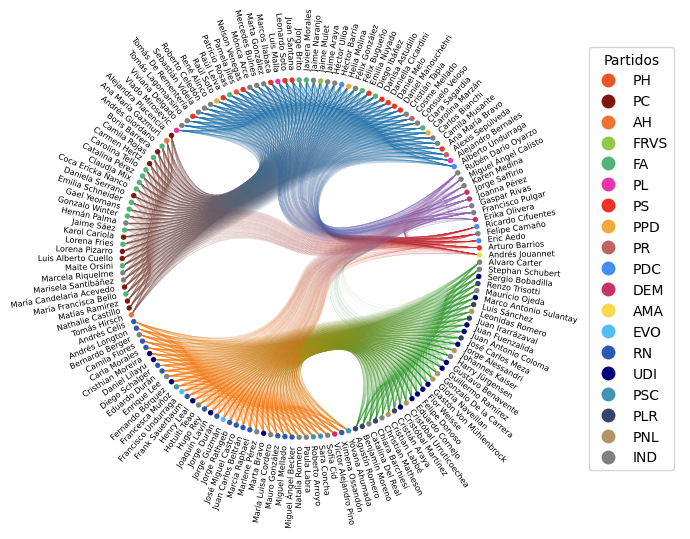

In [295]:
fig, (ax, ax_leg) = plt.subplots(1, 2, figsize=(7, 6), width_ratios=[6, 1])

nodelink_radial.plot(ax,
    nodes=dict(
        node_size=15,
        palette=party_colors.values(),
        edgecolor='none',
        alpha=1,
        fontsize='xx-small',
        text_color="black"
    ), 
    edges=dict(
        alpha=0.5,
        palette="tab10",
        linewidth=0.1*deputy_pairs_valid["percent"]
    )
)

ax.set_axis_off()
ax.set_aspect('equal')

legend_elems = [
    mlines.Line2D(
        [0],
        [0],
        linewidth=0,
        marker="o",
        markersize=10,
        markerfacecolor=color,
        markeredgecolor="none",
        label=party_abbrev
    )
    for party_abbrev, color in party_colors.items()
]
leg = ax_leg.legend(handles=legend_elems, title="Partidos", loc="right")
ax_leg.set_axis_off()

fig.tight_layout()

plt.savefig("img/red.png", dpi=300)